# Twin4Build: Basic Usage Example

Welcome to this tutorial on using the Twin4Build package! In this notebook, you'll learn how to:
1. Create a simple model with a schedule and a damper
2. Connect components in the model
3. Simulate the model
4. Visualize the results

Let's get started!

## 1. Setup
First, let's install and import the necessary packages:

In [1]:
%pip install git+https://github.com/JBjoernskov/Twin4Build.git # Uncomment in google colab
import sys
sys.path.append(r"C:\Users\jabj\Documents\python\Twin4Build")
import twin4build as tb
import datetime
from dateutil import tz
import twin4build.utils.plot.plot as plot

## Creating the Model

Now that we have our packages installed and imported, let's create a simple model.

In [2]:
# Create a new model
model = tb.Model(id="mymodel")
print(model)

+----------------------------------------------------+
|           Model overview    id: mymodel            |
+--------------------------------------------+-------+
| Number of components in simulation model:  |   0   |
+--------------------------------------------+-------+
|   Number of edges in simulation model:     |   0   |
+--------------------------------------------+-------+
|   Number of objects in semantic model:     |   0   |
+--------------------------------------------+-------+
|   Number of triples in semantic model:     |   0   |
+--------------------------------------------+-------+
|                                            |       |
|                                            |       |
+--------------------------------------------+-------+
|                     id                     | Class |
+--------------------------------------------+-------+


C:\Users\jabj\Documents\python\Twin4Build\twin4build\utils\mkdir_in_root.py:5: MainPathNotFound: Could not determine main module path, using temp dir: C:\Users\jabj\AppData\Local\Temp\1
  current_dir = get_main_dir()


### Instantiating Components
As shown by the printout, the model is currently empty.<br>
Let's instantiate two components: a schedule and a damper.<br>
The inputs and outputs of the components are shown in the printout.<br>
Note that any class in the Twin4Build package ending with "System" can be used as a component.<br>
E.g.:


In [3]:
tb.ScheduleSystem
tb.AirToAirHeatRecoverySystem
tb.FanSystem

twin4build.saref4bldg.physical_object.building_object.building_device.distribution_device.distribution_flow_device.flow_moving_device.fan.fan_system.FanSystem

In [4]:
# 1. Create a schedule
position_schedule = tb.ScheduleSystem(
    weekDayRulesetDict = {
        "ruleset_default_value": 0,
        "ruleset_start_minute": [0,0,0,0,0,0,0],
        "ruleset_end_minute": [0,0,0,0,0,0,0],
        "ruleset_start_hour": [6,7,8,12,14,16,18],
        "ruleset_end_hour": [7,8,12,14,16,18,22],
        "ruleset_value": [0,0.1,1,0,0,0.5,0.7]
    },
    id="Position schedule"
)
print("Schedule component:")
print(position_schedule)

# 2. Create a damper
damper = tb.DamperSystem(
    nominalAirFlowRate = tb.PropertyValue(hasValue=1.6),
    a=5,
    id="Damper"
)
print("\nDamper component:")
print(damper)

Schedule component:
+---------------------------------------------+
| Component overview    id: Position schedule |
+-------------+-------------------------------+
|    input    |             output            |
+-------------+-------------------------------+
|             |         scheduleValue         |
+-------------+-------------------------------+

Damper component:
+----------------------------------+
| Component overview    id: Damper |
+----------------+-----------------+
|     input      |      output     |
+----------------+-----------------+
| damperPosition |   airFlowRate   |
+----------------+-----------------+
|                |  damperPosition |
+----------------+-----------------+


### Connecting Components

Now that we have our components, let's connect them in the model.

In [5]:
# Connect the schedule's output to the damper's input
model.add_connection(position_schedule, damper, "scheduleValue", "damperPosition")
print("Components connected successfully!")

# Let's see our updated model
print("\nUpdated model:")
print(model)

Components connected successfully!

Updated model:
+-------------------------------------------------------------+
|                Model overview    id: mymodel                |
+--------------------------------------------+----------------+
| Number of components in simulation model:  |       2        |
+--------------------------------------------+----------------+
|   Number of edges in simulation model:     |       1        |
+--------------------------------------------+----------------+
|   Number of objects in semantic model:     |       2        |
+--------------------------------------------+----------------+
|   Number of triples in semantic model:     |       0        |
+--------------------------------------------+----------------+
|                                            |                |
|                                            |                |
+--------------------------------------------+----------------+
|                     id                     |     Cl

### Loading Model
Before we can simulate the model, we need to load it.<br>
This performs some internal operations and checks to prepare the model and ensure that the model is valid.

In [6]:
model.load()


Loading model...

[OK]
   |___Drawing parsed object graph...[OK]
   |___Drawing system graph...[OK]
   |___Removing cycles...[OK]
   |___Drawing system graph without cycles...[OK]
   |___Determining execution order...[OK]
   |___Creating execution graph...[OK]
   |___Drawing execution graph...[OK]
   |___Loading parameters...[OK]
   |___Validating model...[OK]
   |   |
   |
   |___Validated for Simulator...OK
   |___Validated for Estimator...OK
   |___Validated for Evaluator...OK
   |___Validated for Monitor...OK
   |___

+-------------------------------------------------------------+
|                Model overview    id: mymodel                |
+--------------------------------------------+----------------+
| Number of components in simulation model:  |       2        |
+--------------------------------------------+----------------+
|   Number of edges in simulation model:     |       1        |
+--------------------------------------------+----------------+
|   Number of objects in semantic model:  

### Visualizing the Model (not required)
We can visualize the model to see the components and connections.<br>
This is not required, but it can be helpful for debugging and for building the model.<br>
The nodes in the graph represent components, and the edges represent connections between components as defined earlier.

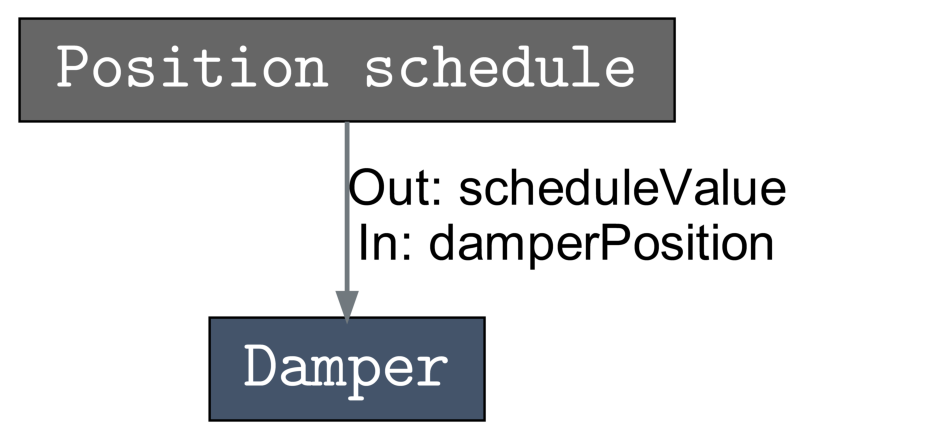

In [7]:
import matplotlib.pyplot as plt
import os
system_graph = os.path.join(model.graph_path, "system_graph.png")
image = plt.imread(system_graph)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.axis('off')
plt.show()

## 2. Simulating the Model

Now that our model is set up, let's simulate it for a 2-day period.

In [8]:
# Set up the simulator and simulation parameters
simulator = tb.Simulator()
stepSize = 600  # Seconds
startTime = datetime.datetime(year=2024, month=1, day=10, hour=0, minute=0, second=0, tzinfo=tz.gettz("Europe/Copenhagen"))
endTime = datetime.datetime(year=2024, month=1, day=12, hour=0, minute=0, second=0, tzinfo=tz.gettz("Europe/Copenhagen"))

# Simulate the model
simulator.simulate(model,
                    stepSize=stepSize,
                    startTime=startTime,
                    endTime=endTime)
print("Simulation completed successfully!")

100%|██████████| 288/288 [00:00<00:00, 31541.88it/s]

Simulation completed successfully!


## Visualizing the Results

Finally, let's visualize the results of our simulation.
We can use the general plot_component function to plot the results of the damper.


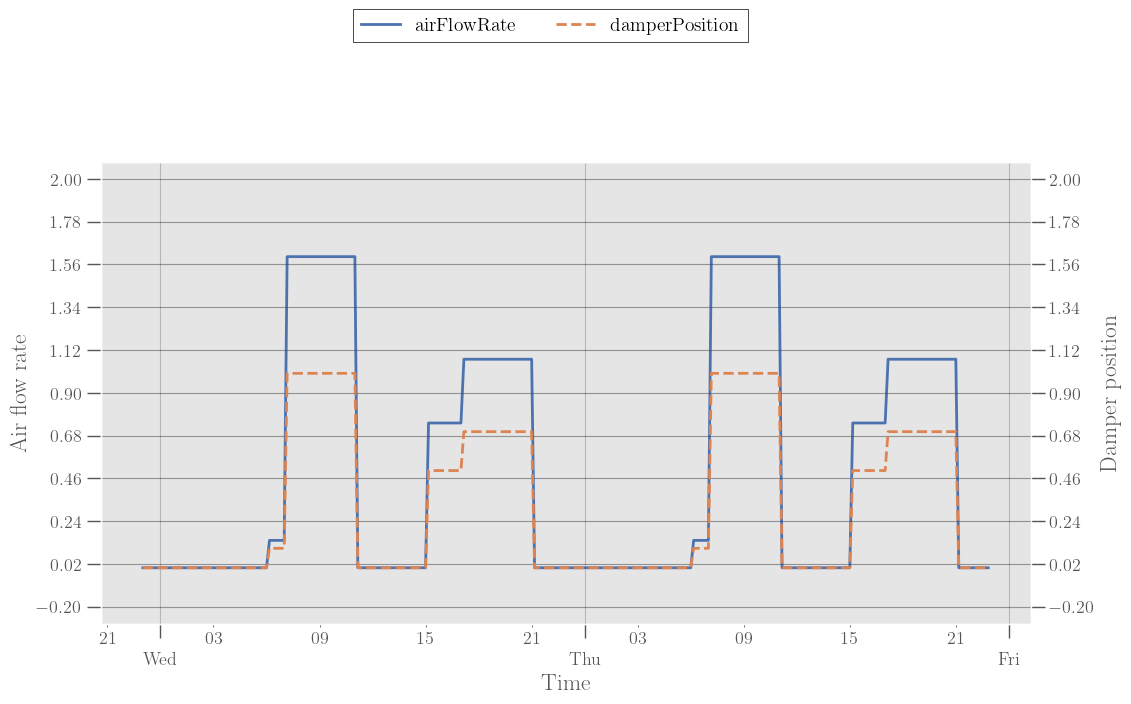

Plot generated successfully!


In [9]:
# Plot the damper results
# plot.plot_damper(model, simulator, "Damper", show=True)
plot.plot_component(simulator, 
                    components_1axis=[("Damper", "airFlowRate")], 
                    components_2axis=[("Damper", "damperPosition")], 
                    ylabel_1axis="Air flow rate", #Optional
                    ylabel_2axis="Damper position", #Optional
                    show=True,
                    nticks=11)
print("Plot generated successfully!")

## Conclusion

Congratulations! You've successfully created a simple Twin4Build model, simulated it, and visualized the results. 

In this tutorial, you learned how to:
1. Create a model and add components (schedule and damper)
2. Connect components in the model
3. Set up and run a simulation
4. Visualize the simulation results

Next steps:
- Try adding more components to create more complex models
- Experiment with different schedules and parameter values
- Explore other visualization options in the `plot` module

For more advanced usage and detailed documentation, please refer to the Twin4Build documentation.